- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [ ]:
import torch
from torch import nn, optim
from sklearn.datasets import load_wine
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import Image
from torchvision import transforms

In [ ]:
data=load_wine()
input = data.data
output = data.target

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [ ]:
print(input.shape) #178개의 sample input 13

(178, 13)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device) #데이터를 gpu로
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test) ##?

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [ ]:
print(x_train[0])
print(y_train[0])

#input 13개 (속성이 13개)
#y의 class는 3개 

tensor([1.3750e+01, 1.7300e+00, 2.4100e+00, 1.6000e+01, 8.9000e+01, 2.6000e+00,
        2.7600e+00, 2.9000e-01, 1.8100e+00, 5.6000e+00, 1.1500e+00, 2.9000e+00,
        1.3200e+03], device='cuda:0')
tensor(0, device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

#case1: 베이스라인 코드 그대로

In [ ]:
from torch.utils.data import Dataset   # Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.
class CustomDataset(Dataset):
  def __init__(self,transform = None):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]  
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device) #객체에 []을 하면 자동으로 x,y 저장됨
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [ ]:
batch_size = 10

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [ ]:
model = nn.Sequential(
          nn.Linear(13,26, bias=True),
          nn.Sigmoid(),
          nn.Linear(26,39, bias=True),
          nn.Sigmoid(),
          nn.Linear(39,3, bias=True), 
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [ ]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,26, bias=True),
          nn.Sigmoid(),
        nn.BatchNorm1d(26)   #input 값 맞춰주기
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(26,39, bias=True),nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(39,52, bias=True),
          nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(52, 3, bias=True), 
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서    

In [ ]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=26, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=26, out_features=39, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=39, out_features=52, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=52, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [ ]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=26, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=26, out_features=39, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=39, out_features=52, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=52, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.153936743736267
10 1.0552979707717896
20 0.9223798513412476
30 0.8678139448165894
40 0.8625806570053101
50 0.8327105045318604
60 0.8046091794967651
70 0.7563766241073608
80 0.7105939984321594
90 0.653317928314209


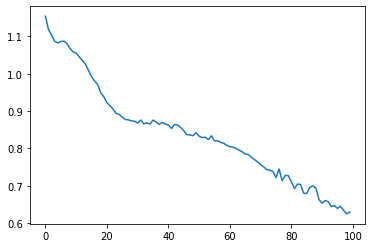

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
print(f'model의 output은 : {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')   #초기 accuracy 약 0.91

model의 output은 : [9.9825186e-01 5.3679406e-07 1.7474985e-03]
argmax를 한 후의 output은 0
accuracy는 0.9074074074074074


# case 2: 전처리: normalize 추가

In [ ]:
print(x_train.mean(),x_train.std())

tensor(4.8869, device='cuda:0') tensor(6.0144, device='cuda:0')


In [ ]:
from torch.utils.data import Dataset  
class CustomDataset(Dataset):
  def __init__(self,transform = None):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]  
    self.transform = transform 
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device) #객체에 []을 하면 자동으로 x,y 저장됨
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y


torchvision_transform = transforms.Normalize(4.8869, 6.0144, inplace=False)  #추가한 부분


batch_size = 10

dataset = CustomDataset(transform=torchvision_transform)
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [ ]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,26, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(26)   #input 값 맞춰주기
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(26,39, bias=True),
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(39,52, bias=True), 
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(52, 3, bias=True), 
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)  

model = Model().to(device)
model.apply(init_weights)    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=26, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=26, out_features=39, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=39, out_features=52, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=52, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.1176129579544067
10 0.9931424856185913
20 0.8746321201324463
30 0.8510243892669678
40 0.8474462628364563
50 0.8404250144958496
60 0.8381294012069702
70 0.8249585032463074
80 0.7662920951843262
90 0.764864444732666


In [ ]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'accuracy는 {accuracy}')  #0.91로 성능 동일(normarlize가 이미 포함된 데이터임)

accuracy는 0.5555555555555556


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


#case 3: relu 함수+ layer 수 1개로 줄이기

In [ ]:
import numpy as np

def relu(x):
	return np.maximum(0, x)

In [ ]:
from torch.utils.data import Dataset  
class CustomDataset(Dataset):
  def __init__(self,transform = None):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]  
    self.transform = transform 
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device) #객체에 []을 하면 자동으로 x,y 저장됨
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y


torchvision_transform = transforms.Normalize(4.8869, 6.0144, inplace=False)  #추가한 부분


batch_size = 10

dataset = CustomDataset(transform=torchvision_transform)
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [ ]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,26, bias=True),
          nn.ReLU(),
        nn.BatchNorm1d(26)   #input 값 맞춰주기
    ) 

    self.layer2 = nn.Sequential(
          nn.Linear(26,3, bias=True), 
        nn.ReLU()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    return output

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)  

model = Model().to(device)
model.apply(init_weights)    


loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'accuracy는 {accuracy}')  #0.72로 낮아짐 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


0 1.246024489402771
10 0.7162477970123291
20 0.6224349737167358
30 0.5459978580474854
40 0.48217323422431946
50 0.43875351548194885
60 0.39589571952819824
70 0.3665273189544678
80 0.34330540895462036
90 0.3233625590801239
accuracy는 0.7222222222222222


# case 4: relu 함수+ layer 수 그대로+노드 바꿔보기+lr->0.03



In [ ]:
from torch.utils.data import Dataset  
class CustomDataset(Dataset):
  def __init__(self,transform = None):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]  
    self.transform = transform 
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device) #객체에 []을 하면 자동으로 x,y 저장됨
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y


torchvision_transform = transforms.Normalize(4.8869, 6.0144, inplace=False)  #추가한 부분


batch_size = 10

dataset = CustomDataset(transform=torchvision_transform)
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [ ]:
class Model1(torch.nn.Module):

  def __init__(self):
    super(Model1, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,10, bias=True), 
          nn.ReLU(),
        nn.BatchNorm1d(10)   #input 값 맞춰주기
    )

    self.layer2 = nn.Sequential(
          nn.Linear(10,7, bias=True),
          nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(7,6, bias=True),
          nn.ReLU())
    
    self.layer4 = nn.Sequential(
          nn.Linear(6,3, bias=True),
          nn.ReLU()
    )    
    
  def forward(self,x):
      output = self.layer1(x)
      output = self.layer2(output)
      output = self.layer3(output)
      output = self.layer4(output)
      return output

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서  

model = Model1().to(device)
model.apply(init_weights)    


loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.03)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

with torch.no_grad():
  model1 = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'accuracy는 {accuracy}')  #0.94

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


0 1.0402253866195679
10 0.7123870253562927
20 0.5942121148109436
30 0.5908019542694092
40 0.4673052430152893
50 0.45830318331718445
60 0.4081529378890991
70 0.2634502053260803
80 0.17430885136127472
90 0.07419569790363312
accuracy는 0.9444444444444444


# case 5: relu 함수+ layer 수 그대로+노드 바꿔보기+lr:0.05+dropout

In [ ]:
from torch.utils.data import Dataset  
class CustomDataset(Dataset):
  def __init__(self,transform = None):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]  
    self.transform = transform 
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device) #객체에 []을 하면 자동으로 x,y 저장됨
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y


torchvision_transform = transforms.Normalize(4.8869, 6.0144, inplace=False)  #추가한 부분


batch_size = 10

dataset = CustomDataset(transform=torchvision_transform)
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [ ]:
class Model2(torch.nn.Module):

  def __init__(self):
    super(Model2, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,10, bias=True), 
          nn.ReLU(),
        nn.BatchNorm1d(10)   #input 값 맞춰주기
    )

    self.layer2 = nn.Sequential(
          nn.Linear(10,7, bias=True),
          nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(7,6, bias=True),
          nn.ReLU())
    
    self.layer4 = nn.Sequential(
          nn.Linear(6,3, bias=True),
          nn.ReLU()
    ) 

    self.dropout = nn.Dropout(0.25)      
    
  def forward(self,x):
      output = self.layer1(x)
      output = self.layer2(output)
      output = self.layer3(output)
      output = self.dropout(output)      
      output = self.layer4(output)
      return output

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서  

model = Model().to(device)
model.apply(init_weights)    


loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.05)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'accuracy는 {accuracy}')  #0.67로 낮아짐

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


0 1.2648327350616455
10 0.8121306896209717
20 0.7291269898414612
30 0.7110924124717712
40 0.7343065142631531
50 0.6494840383529663
60 0.6406269669532776
70 0.5395769476890564
80 0.5073202848434448
90 0.5579782724380493
accuracy는 0.6666666666666666


# case 6: relu 함수+ layer 수 그대로+노드 바꿔보기+lr:0.05+SGD

In [ ]:
from torch.utils.data import Dataset  
class CustomDataset(Dataset):
  def __init__(self,transform = None):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]  
    self.transform = transform 
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device) #객체에 []을 하면 자동으로 x,y 저장됨
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y


torchvision_transform = transforms.Normalize(4.8869, 6.0144, inplace=False)  #추가한 부분


batch_size = 10

dataset = CustomDataset(transform=torchvision_transform)
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [ ]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,10, bias=True), 
          nn.ReLU(),
        nn.BatchNorm1d(10)   #input 값 맞춰주기
    )

    self.layer2 = nn.Sequential(
          nn.Linear(10,7, bias=True),
          nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(7,6, bias=True),
          nn.ReLU())
    
    self.layer4 = nn.Sequential(
          nn.Linear(6,3, bias=True),
          nn.ReLU()
    ) 
   
    
  def forward(self,x):
      output = self.layer1(x)
      output = self.layer2(output)
      output = self.layer3(output)    
      output = self.layer4(output)
      return output

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서  

model = Model().to(device)
model.apply(init_weights)    


loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr= 0.05)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'accuracy는 {accuracy}')  #0.33으로 낮아짐

0 1.1428662538528442
10 0.9605160355567932
20 0.8848334550857544
30 0.8578853011131287
40 0.8469720482826233
50 0.8414644598960876
60 0.8373143672943115
70 0.8361294269561768
80 0.8343256711959839
90 0.8335631489753723
accuracy는 0.3333333333333333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


##이외에도 여러번 시도 결과

##case4:relu 함수+ layer 수 그대로(4개)+노드 바꿔보기(13,10,7,6,3)+lr->0.03 이 약 94%로 가장 높았음